Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import code from repository

In [ ]:
!rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
!git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"

Cloning into '/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 260 (delta 11), reused 26 (delta 11), pack-reused 234
Receiving objects: 100% (260/260), 49.29 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (142/142), done.


# Clone dataset repository and load data

In [ ]:
!rm -r "/content/patch_dataset_noisy"
!git clone https://github.com/frpnz/dataset-BIOSTEC2018-noisy.git "/content/patch_dataset_noisy"

import zipfile
import numpy as np
from PIL import Image
filepath = "/content/patch_dataset_noisy/crc_3_noisy.zip"
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall("/content/patch_dataset_noisy")
X_test_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/X_test.npy")
Y_test_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/Y_test.npy")
X_train_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/X_train.npy")
Y_train_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/Y_train.npy")
x_mean_train = np.load("/content/patch_dataset_noisy/crc_3_noisy/mean_x_train.npy")

# Undo preprocessing to plot images
X_train_noisy = X_train_noisy*255 + x_mean_train
X_train_noisy = X_train_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_train_noisy))
np.random.shuffle(indexes)
X_train_noisy = X_train_noisy[indexes]
Y_train_noisy = Y_train_noisy[indexes]
# Undo preprocessing to plot images
X_test_noisy = X_test_noisy*255 + x_mean_train
X_test_noisy = X_test_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_test_noisy))
np.random.shuffle(indexes)
X_test_noisy = X_test_noisy[indexes]
Y_test_noisy = Y_test_noisy[indexes]

Cloning into '/content/patch_dataset_noisy'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (4/4), done.


In [ ]:
import os
import sys
import pickle
import openslide
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
import matplotlib.pyplot as plt
import openslide.deepzoom as dz
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
ROOTDIR_DATA = "/content/patch_dataset/crc_images"
ROOTDIR_SRC = "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP/src"
ROOTDIR_OUTPUT = "/content/models"
plt.style.use(os.path.join(ROOTDIR_SRC, "mystyle.mplstyle"))
import sys
sys.path.append(ROOTDIR_SRC)

In [ ]:
from resnet import ResNet
from wsi_utils import DatasetManager
from sklearn import model_selection
from wsi_utils import get_heatmap
from utils import seaborn_cm
import matplotlib.pyplot as plt

In [ ]:
output_dir = os.path.join(ROOTDIR_OUTPUT, "models_crc")
checkpoint_filename = "HvsNH.h5"
n_splits = 1
tile_new_size = 64
epochs = 25
learning_rate = 0.001
batch_size = 128
channels = 3
num_classes = 3
class_dict = {
    0: "AC",
    1: "AD",
    2: "H"
}
try:
    os.makedirs(output_dir)
except FileExistsError:
    print("{} exists.".format(output_dir))
input_shape = (tile_new_size, tile_new_size, channels)
checkpoint_filepath = os.path.join(output_dir, checkpoint_filename)

# Resize to tile_new_size
X_test_noisy = np.array([np.array(Image.fromarray(x).resize((tile_new_size, tile_new_size), Image.ANTIALIAS)) for x in X_test_noisy])
X_train_noisy = np.array([np.array(Image.fromarray(x).resize((tile_new_size, tile_new_size), Image.ANTIALIAS)) for x in X_train_noisy])

/content/models/models_crc exists.


## Prepare tf dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_noisy, Y_train_noisy))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_noisy, Y_test_noisy))

## Show some images with correspondig label as title

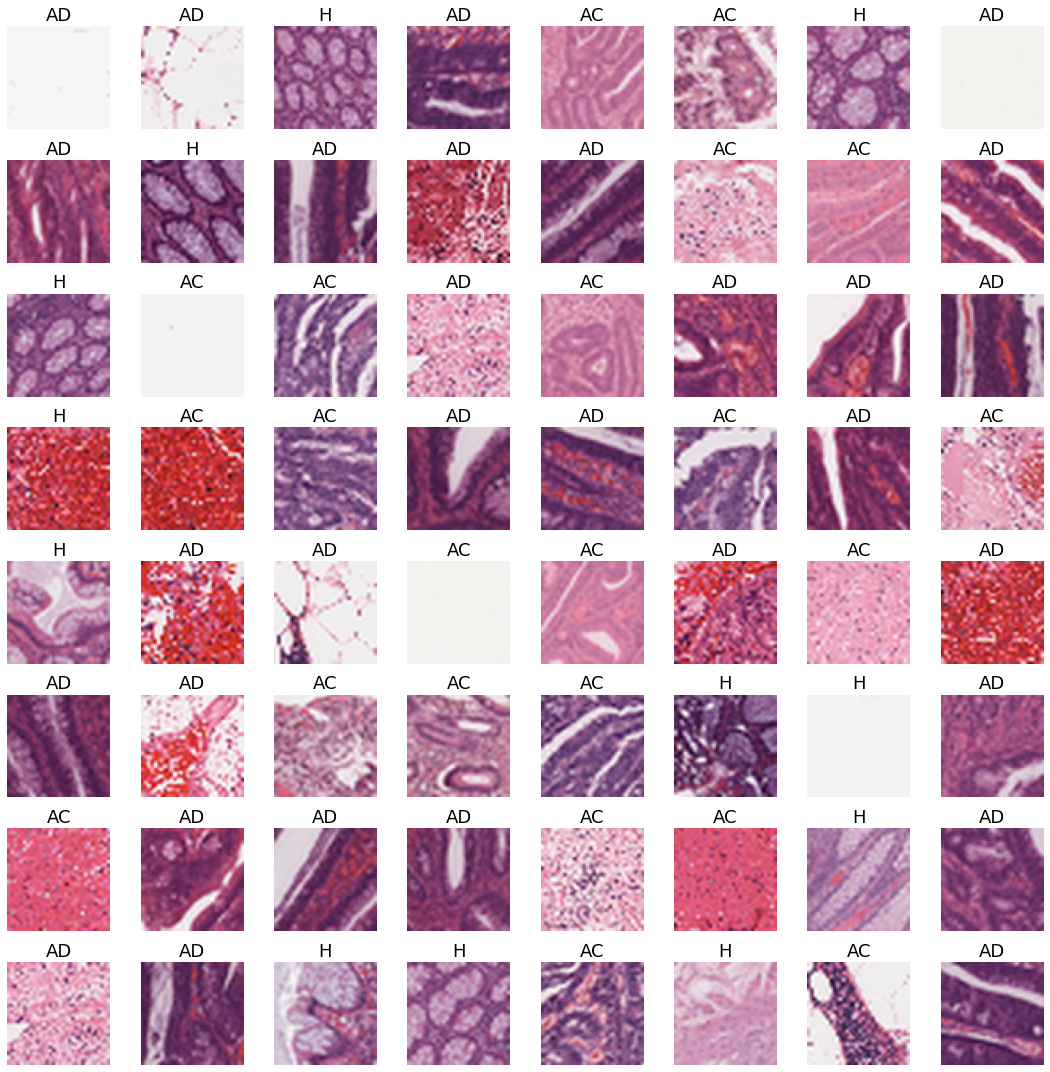

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
ax = ax.ravel()
i = 0
for image, label in test_ds.take(64):
    ax[i].imshow(image.numpy().astype("uint8"))
    ax[i].set_title(class_dict[label.numpy()])
    ax[i].axis("off")
    i += 1
plt.tight_layout()

## Prepare tf dataset pipeline

In [ ]:
train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=len(X_train_noisy))
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
y_true = np.array([y.numpy() for x, y in test_ds])
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# CNN definition and training
You must implement:


1.   An augmentation block
2.   Three callbacks: 

           A) tf.keras.callbacks.ModelCheckpoint
           B) tf.keras.callbacks.EarlyStopping
           C) tf.keras.callbacks.ReduceLROnPlateau


In [ ]:
augmentation_block = [
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    tf.keras.layers.RandomRotation(0.3),
]
inputs = tf.keras.Input(input_shape)
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
for layer in augmentation_block:
    x = layer(x, training=False)
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet")
for j, layer in enumerate(base_model.layers[:100]):
    layer.trainable = False
x = base_model(x)
x = tf.keras.layers.Dropout(0.5)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.001,
    patience=15,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
model.fit(train_ds, epochs=50, callbacks=[checkpoint_callback, lr_callback, early_stop_callback])
print("Loading {}".format(checkpoint_filepath))
model = tf.keras.models.load_model(checkpoint_filepath)

Epoch 1/50
97/97 [==============================] - 15s 93ms/step - loss: 1.1431 - accuracy: 0.4434 - lr: 0.0010
Epoch 2/50
97/97 [==============================] - 8s 78ms/step - loss: 0.8682 - accuracy: 0.5850 - lr: 0.0010
Epoch 3/50
97/97 [==============================] - 8s 78ms/step - loss: 0.7542 - accuracy: 0.6447 - lr: 0.0010
Epoch 4/50
97/97 [==============================] - 8s 78ms/step - loss: 0.6849 - accuracy: 0.6869 - lr: 0.0010
Epoch 5/50
97/97 [==============================] - 8s 79ms/step - loss: 0.6277 - accuracy: 0.7144 - lr: 0.0010
Epoch 6/50
97/97 [==============================] - 8s 78ms/step - loss: 0.5966 - accuracy: 0.7267 - lr: 0.0010
Epoch 7/50
97/97 [==============================] - 8s 78ms/step - loss: 0.5759 - accuracy: 0.7341 - lr: 0.0010
Epoch 8/50
97/97 [==============================] - 8s 78ms/step - loss: 0.5444 - accuracy: 0.7506 - lr: 0.0010
Epoch 9/50
97/97 [==============================] - 8s 79ms/step - loss: 0.5265 - accuracy: 0.7562 - lr

## Test the model
Plot a confusion matrix

@@@@@@@@@@@@@@
Accuracy: 0.66
@@@@@@@@@@@@@@


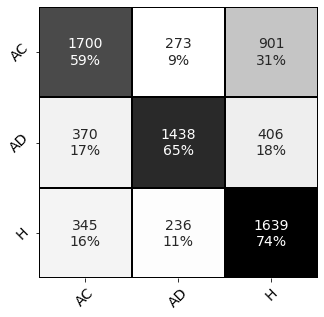

In [ ]:
y_pred = model.predict(test_ds, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)
mean_acc = np.mean(np.diag(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]))
print("@" * len("Accuracy: {:.2f}".format(mean_acc)))
print("Accuracy: {:.2f}".format(mean_acc))
print("@" * len("Accuracy: {:.2f}".format(mean_acc)))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
seaborn_cm(cm, ax, sorted(["AC", "AD", "H"]))

# Selective classification applied to histological images

TTA Wrapper

In [1]:
class TTAWrapper:
    def __init__(self, keras_model, input_shape=(32, 32, 3)):
        super(TTAWrapper, self).__init__()
        self.model = keras_model
        self._input_shape = input_shape
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def predict_many_times(self, ds, policy, draws=1):
        pred_augmented = list()

        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(int(self._input_shape[0] - 0.1*self._input_shape[0]),
                                           int(self._input_shape[0] - 0.1*self._input_shape[0])),
                tf.keras.layers.Resizing(self._input_shape[0],
                                         self._input_shape[1])])]

        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal_and_vertical")])
        ]

        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.2, 0.2)])
        ]

        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(height_factor=(-0.2, .2),
                                           width_factor=(-0.2, .2))])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip
        policies['all'] = sum([policy_random_crop, policy_random_contrast, policy_random_zoom, policy_random_flip], [])

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(draws)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(draws)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(draws)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(draws)], [])
        policies['all'] = sum([policies['all'] for _ in range(draws)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.model.predict(ds_augmented))

        return pred_augmented